In [1]:
%load_ext autoreload
%autoreload 2

import copy
import collections
from contextlib import contextmanager
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from itertools import islice
import re
from typing import *
import unittest.mock as um

import numpy as np
import torch
from torch import nn, Tensor
import transformers
import datasets
import lm_eval.evaluator
import lm_eval.tasks
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import llminference as L
import llminference.experiments as xp

torch.set_num_threads(32)
CACHE = "/net/group/research/douglaso/llminference-cache"

In [2]:
# adapter = L.Adapter.from_pretrained("EleutherAI/pythia-160m")
adapter = L.Adapter.from_pretrained("EleutherAI/pythia-1.4b")
original_model = adapter.model
data = L.qa.SQuAD.data()
examples = [L.qa.add_few_shot_prompt(data[i], k=1, prompt_template=L.qa.get_default_prompt_template(adapter.model.config._name_or_path, shots=1)) for i in range(400)]
# data = L.qa.TriviaQA.data()
# examples = [L.qa.add_zero_shot_prompt(data[i]) for i in range(400)]

Found cached dataset squad (/nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-03400b5d173ab796.arrow
Loading cached shuffled indices for dataset at /nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-c374d8616db3e9e0.arrow


In [176]:
adapter.model = L.ann_attention.convert_gptneox(
    original_model,
    # L.ann_attention.Settings(256, 64, rank=16, method="low_rank", init="orthonormal"),  # 0.2
    L.ann_attention.Settings(256, 64, rank=16, method="max_components", init=None),  # 0.3
)
# layer = adapter.model.gpt_neox.layers[12].attention
# layer.detailed_logging = True
# layer.coverage_mode_k = 32
# for layer in adapter.model.gpt_neox.layers:
#     layer.attention.coverage_mode_k = 32
#     layer.attention.detailed_logging = True
out = list(L.qa.evaluate(adapter, examples[:10], batch_size=10, use_cache=False))
display(pd.DataFrame.from_dict(out).match.mean())
display(out[0]["output"])

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [01:35<00:00, 95.52s/it]


0.3

' steam plants\nQuestion: What is the power-to-weight ratio of a steam plant compared to that of an internal combustion'

In [134]:
q, k, m = layer.qkm[0]
_, n_heads, _, head_size = q.shape
true_a = nn.functional.log_softmax(q @ k.transpose(-1, -2) * head_size**-.5 + m, dim=-1)
print(tuple(q.shape), tuple(k.shape), tuple(true_a.shape))

(10, 16, 1, 128) (10, 16, 1793, 128) (10, 16, 1, 1793)


In [146]:
def get_nonmasked(a: Tensor) -> Tensor:
    return a[m.expand(a.shape) > -1e-38]

KL div 49.5105094909668


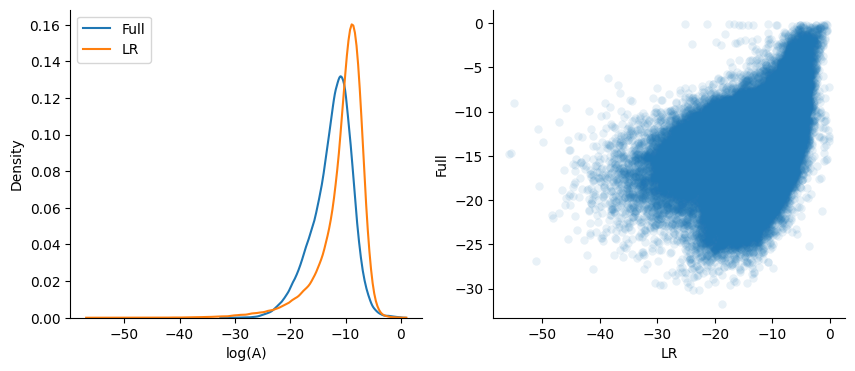

In [166]:
rank = 32
torch.manual_seed(100)
proj = torch.randn(n_heads, head_size, rank) * head_size**-.5
for i in range(n_heads):
    nn.init.orthogonal_(proj[i])
lr_a = nn.functional.log_softmax(
    (q @ proj) @ (k @ proj).transpose(-1, -2)
    * rank**-.5 + m, dim=-1)

print("KL div", float(nn.functional.kl_div(lr_a, true_a, log_target=True, reduction="batchmean")))
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(get_nonmasked(true_a), label="Full", ax=ax0)
sns.kdeplot(get_nonmasked(lr_a), label="LR", ax=ax0)
ax0.legend(); ax0.set_xlabel("log(A)"); sns.despine(ax=ax0)
sns.scatterplot(y=get_nonmasked(true_a), x=get_nonmasked(lr_a), linewidth=0, alpha=.1, ax=ax1)
ax1.set_xlabel("LR"); ax1.set_ylabel("Full"); sns.despine(ax=ax1)

KL div 13.68342113494873


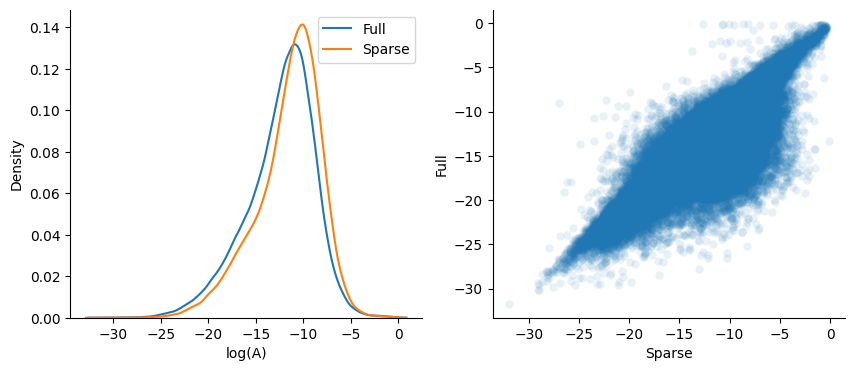

In [169]:
rank = 32
# [k00 k01 k02 k03
#  k10 k11 k12 k13
#  k20 k21 k22 k23]

# q = [0, -3, 2, 1]
#     [0   x  x  0]
#     [1-bit 4-bit 4-bit 2-bit]

# [0 k01 k02 0
#  0 k11 k12 0
#  0 k21 k22 0]

components = q.abs().topk(dim=-1, k=rank).indices
# components = torch.randint(0, head_size, q.shape[:-1] + (rank,))
sp_a = nn.functional.log_softmax(
    q.gather(-1, components) @ k.gather(-1, components.expand(k.shape[:-1] + (rank,))).transpose(-1, -2)
    * head_size**-.5
    # * rank**-.5
    + m, dim=-1)

print("KL div", float(nn.functional.kl_div(sp_a, true_a, log_target=True, reduction="batchmean")))
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(get_nonmasked(true_a), label="Full", ax=ax0)
sns.kdeplot(get_nonmasked(sp_a), label="Sparse", ax=ax0)
ax0.legend(); ax0.set_xlabel("log(A)"); sns.despine(ax=ax0)
sns.scatterplot(y=get_nonmasked(true_a), x=get_nonmasked(sp_a), linewidth=0, alpha=.1, ax=ax1)
ax1.set_xlabel("Sparse"); ax1.set_ylabel("Full"); sns.despine(ax=ax1)

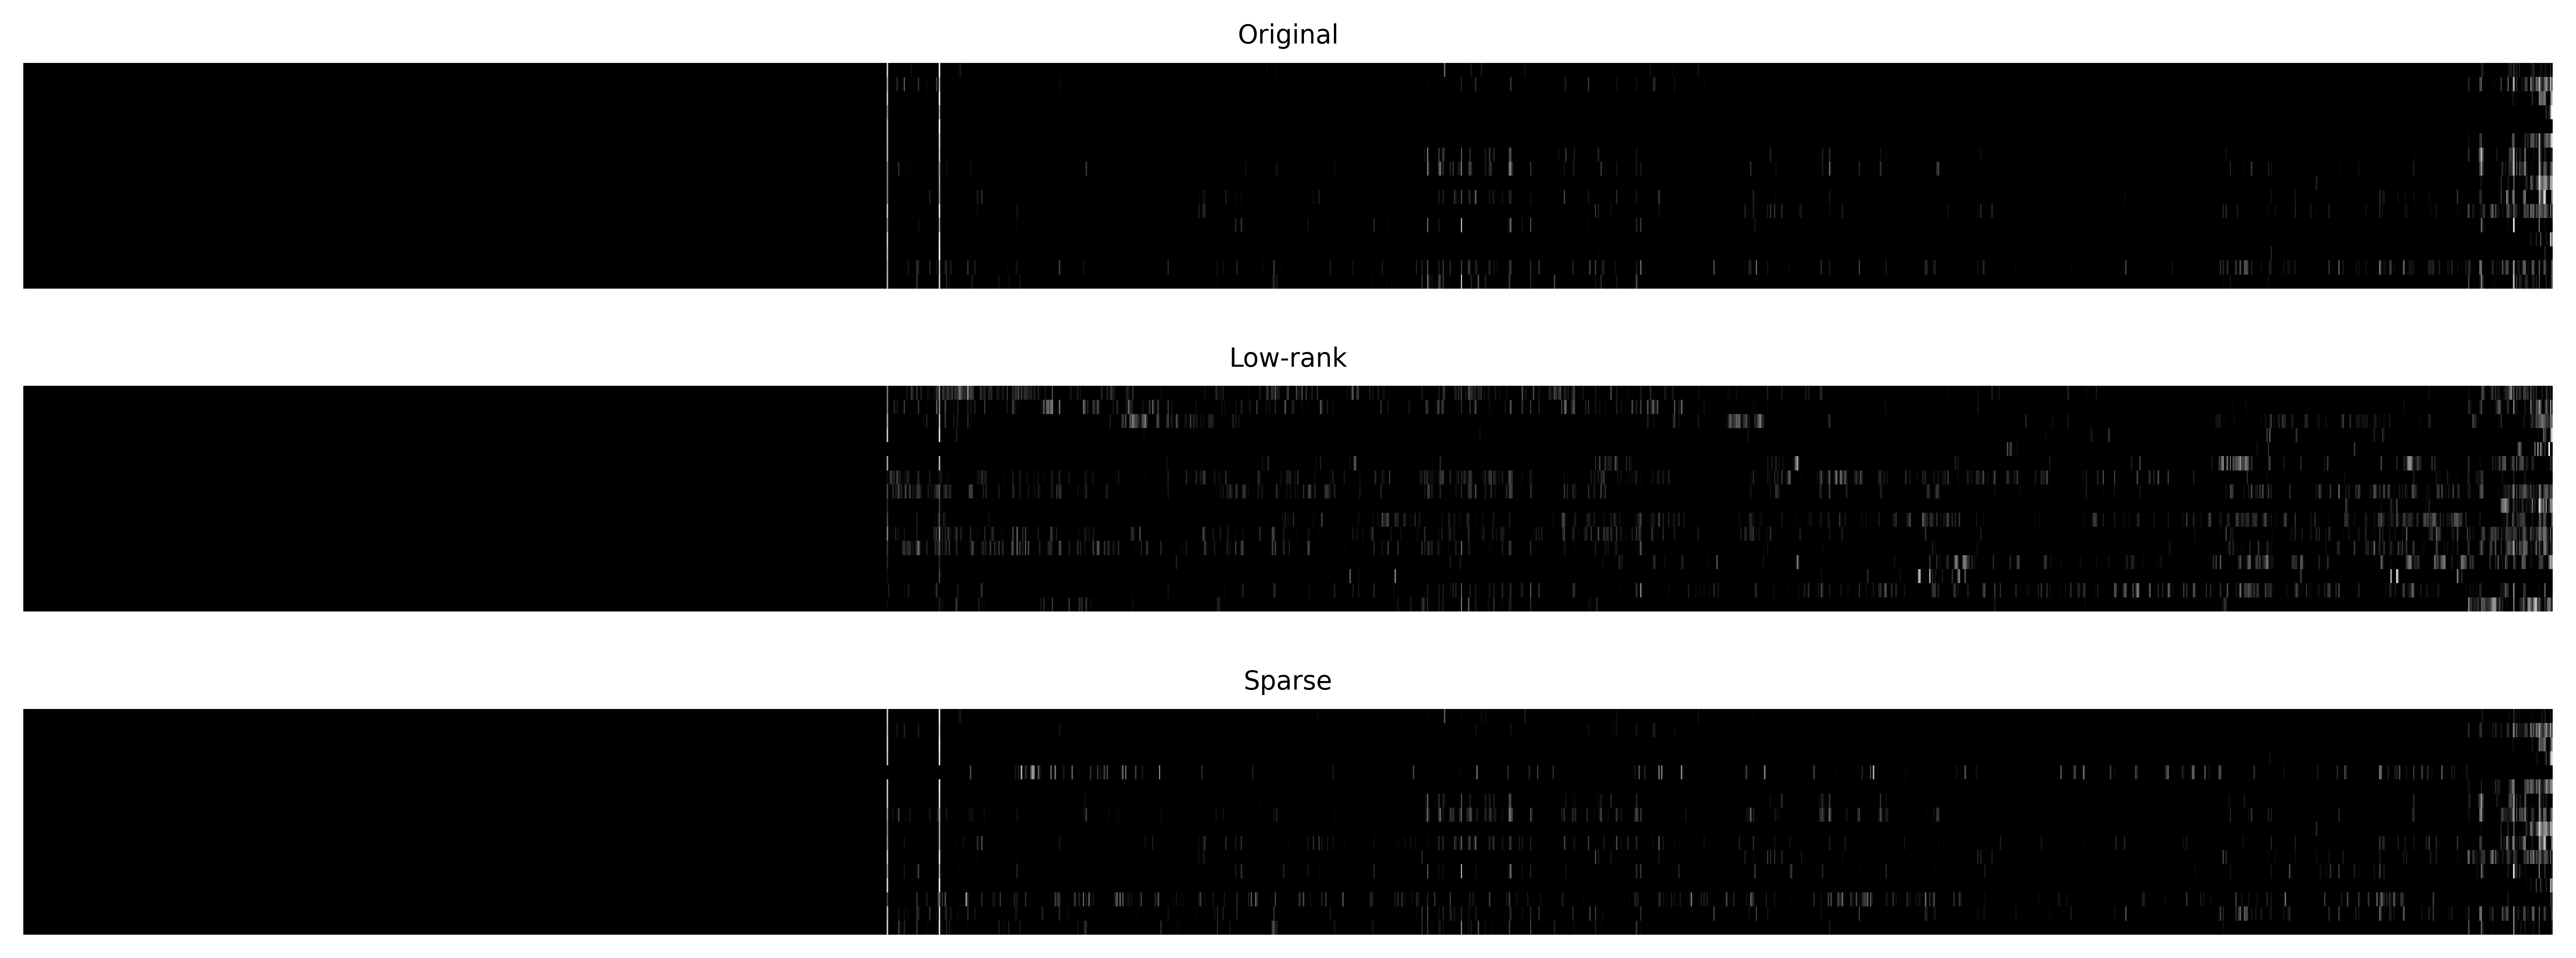

In [163]:
_, axs = plt.subplots(3, 1, figsize=(14, 3*1.7), dpi=600)
for ax, a, name in zip(axs, [true_a, lr_a, sp_a], ["Original", "Low-rank", "Sparse"]):
    ax.imshow(a[0, :, 0], aspect=10, cmap="gray", vmin=-7, vmax=0)
    ax.axis("off")
    ax.set_title(name, fontsize=8)

In [35]:
adapter.model.gpt_neox.layers[0].attention.ann_masks[0].shape

torch.Size([2, 16, 1, 1313])

(-0.5, 1312.5, 15.5, -0.5)

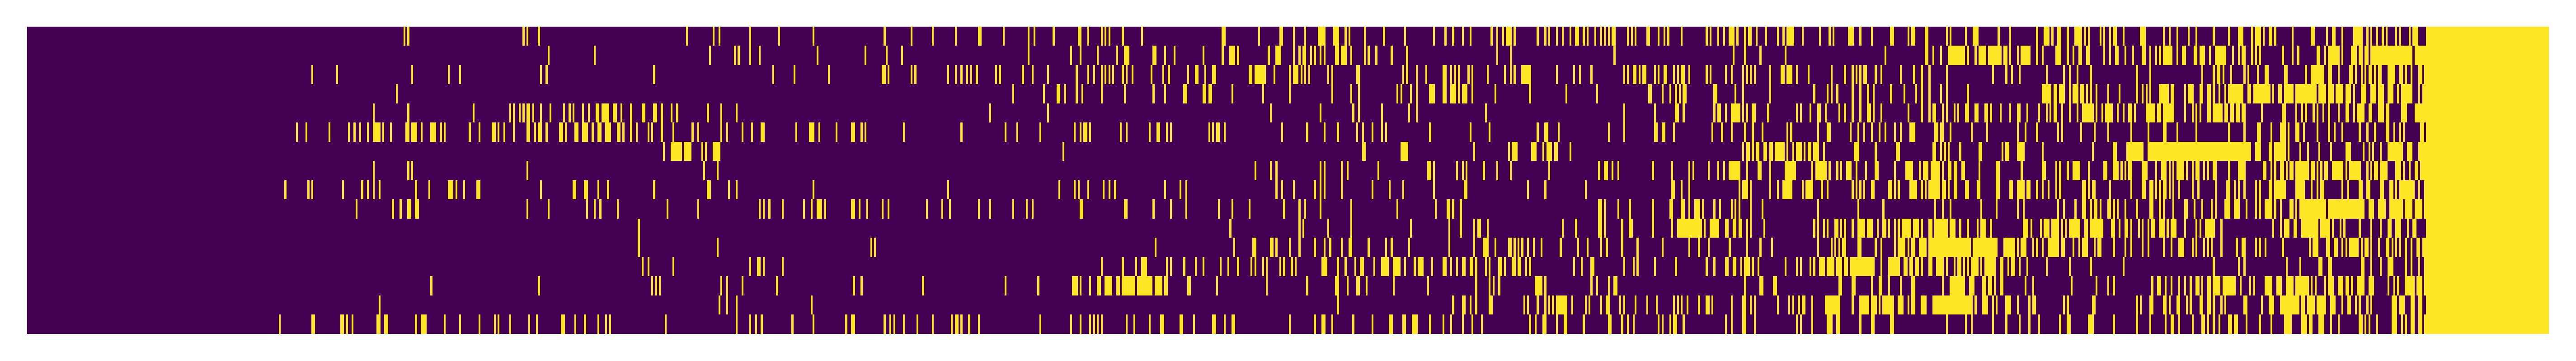

In [34]:
plt.figure(figsize=(12, 3), dpi=600)
plt.imshow(adapter.model.gpt_neox.layers[0].attention.ann_masks[0][0, :, 0, :], aspect=10)
plt.axis("off")

In [10]:
out

[{'id': '5711607f2419e314009555cf',
  'output': ' steam plants\nQuestion: What is the power',
  'match': False,
  'prefill_length': 1180},
 {'id': '570d4329fed7b91900d45dd7',
  'output': ' 1 July 1851\nQuestion: What is',
  'match': True,
  'prefill_length': 1311}]

In [36]:
print(examples[0]["prompt"])


Question: What is the power-to-weight ratio of a steam plant compared to that of an internal combustion engine?
Answer: lower
Question: What plants create most electric power?
Answer:


In [13]:
print(examples[0]["context"] + examples[0]["prompt"])

Title: Southern California. Background: Rugby is also a growing sport in southern California, particularly at the high school level, with increasing numbers of schools adding rugby as an official school sport.
Title: Prime number. Background: A large body of mathematical work would still be valid when calling 1 a prime, but Euclid's fundamental theorem of arithmetic (mentioned above) would not hold as stated. For example, the number 15 can be factored as 3 · 5 and 1 · 3 · 5; if 1 were admitted as a prime, these two presentations would be considered different factorizations of 15 into prime numbers, so the statement of that theorem would have to be modified. Similarly, the sieve of Eratosthenes would not work correctly if 1 were considered a prime: a modified version of the sieve that considers 1 as prime would eliminate all multiples of 1 (that is, all other numbers) and produce as output only the single number 1. Furthermore, the prime numbers have several properties that the number 1

In [14]:
examples[0]["answers"]

['steam turbine',
 'steam turbine',
 'steam turbine plant',
 'steam turbine plant']

In [4]:
adapter.model = L.eviction_attention.convert_gptneox(
    original_model, L.eviction_attention.Settings(k=256, local_k=64, importance=L.eviction_attention.Importance.Settings(
        metric="weight", metric_threshold=None, reduction="sum", reduction_decay=None,
    )),
)
out = list(L.qa.evaluate(adapter, examples[:10], batch_size=10, use_cache=False))
display(pd.DataFrame.from_dict(out).match.mean())

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [01:58<00:00, 118.66s/it]


0.2

In [5]:
adapter.model = L.eviction_attention.convert_gptneox(
    original_model, L.eviction_attention.Settings(k=256, local_k=64, importance=L.eviction_attention.Importance.Settings(
        metric="weight", metric_threshold=None, reduction="sum", reduction_decay=None,
    )),
)
out_original = list(L.qa.evaluate(adapter, examples[:10], batch_size=10, use_cache=False))
display(pd.DataFrame.from_dict(out_original).match.mean())

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [01:40<00:00, 100.73s/it]


0.2

In [84]:
coverage_by_rank = {}
for rank in [16, 32, 64, 128, 256]:
    adapter.model = L.ann_attention.convert_gptneox(original_model, L.ann_attention.Settings(k=256, local_k=64, rank=rank))
    for layer in adapter.model.gpt_neox.layers:
        layer.attention.coverage_mode_k = 32
    out = list(L.qa.evaluate(adapter, examples[:10], batch_size=10, use_cache=False, output_token_limit=2))
    coverage_by_rank[rank] = torch.stack([layer.attention.coverage[0].mean(0) for layer in adapter.model.gpt_neox.layers])

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [01:08<00:00, 68.64s/it]


In [89]:
{k: float(v.mean()) for k, v in coverage_by_rank.items()}

{16: 0.7373208999633789,
 32: 0.7927408218383789,
 64: 0.831469714641571,
 128: 0.874194324016571,
 256: 0.9027913212776184}

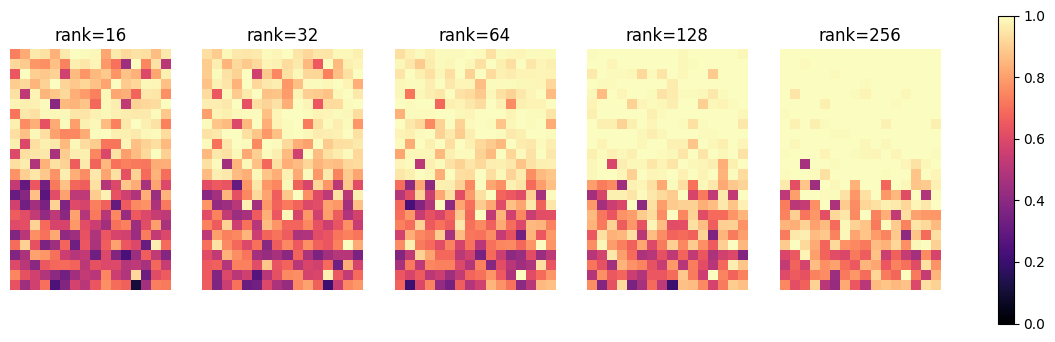

In [107]:
_, axs = plt.subplots(1, len(coverage_by_rank), squeeze=True, figsize=(3 * len(coverage_by_rank), 4))
for ax, (rank, coverage) in zip(axs, coverage_by_rank.items()):
    c = ax.imshow(coverage, cmap="magma", vmin=0, vmax=1)
    ax.set_title(f"rank={rank}")
    ax.axis("off")
plt.colorbar(ax.images[0], ax=axs)

In [69]:
replacement.coverage[0].shape

torch.Size([2, 16])

In [61]:
from transformers.models.gpt_neox.configuration_gpt_neox import GPTNeoXConfig
from transformers.models.gpt_neox.modeling_gpt_neox import GPTNeoXAttention

@dataclass
class Settings:
    k: int
    local_k: int
    rank: int


class LowRankANN(nn.Module):
    def __init__(self, head_size: int, settings: Settings):
        super().__init__()
        self.settings = settings
        self.proj = nn.Linear(head_size, settings.rank, bias=False)

    def topk_mask(self, query: Tensor, key: Tensor, logmask: Tensor) -> Tensor:
        score = self.proj(query) @ self.proj(key).transpose(-1, -2)
        score += logmask

        causal_index = L.sparse_attention.causal_index(logmask[:, :, -1, :])
        is_local = (0 <= causal_index) & (causal_index < self.settings.local_k)
        score.masked_fill_(is_local[:, :, None, :], torch.finfo(score.dtype).max)
        return L.sparse_attention.topk_mask(score, k=self.settings.k)


class GPTNeoXAttentionWithANN(GPTNeoXAttention):  # type:ignore[misc]
    def __init__(self, config: GPTNeoXConfig, settings: Settings):
        super().__init__(config)
        self.ann = LowRankANN(self.head_size, settings)
        self.detailed_logging = False
        self.quiet_mode = False
        self.ann_masks = []
        self.topk_masks = []

    def _attn(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        attention_mask: Optional[Tensor] = None,
        head_mask: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Tensor]:
        assert attention_mask is not None
        if query.shape[-2] == 1:
            ann_mask = self.ann.topk_mask(query, key, attention_mask)
            if not self.quiet_mode:
                attention_mask = attention_mask + torch.finfo(torch.float32).min * ~ann_mask
            if self.detailed_logging:
                self.ann_masks.append(ann_mask)
        output, weights = super()._attn(query, key, value, attention_mask, head_mask)
        if query.shape[-2] == 1 and self.detailed_logging:
            self.topk_masks.append(L.sparse_attention.topk_mask(weights, k=self.ann.settings.k))
        return output, weights


for rank in [16, 32, 64, 128, 256]:
    adapter.model = copy.deepcopy(original_model)
    parent = adapter.model.gpt_neox.layers[0]
    replacement = GPTNeoXAttentionWithANN(adapter.model.config, Settings(k=256, local_k=64, rank=rank))
    replacement.load_state_dict(parent.attention.state_dict(), strict=False)
    replacement.detailed_logging = True
    replacement.quiet_mode = True
    parent.attention = replacement

    out = list(L.qa.evaluate(adapter, examples[:2], batch_size=2, use_cache=False, output_token_limit=2))
    # display(out)
    agreement = (replacement.topk_masks[0] * replacement.ann_masks[0]).float().mean() / replacement.topk_masks[0].float().mean()
    print(rank, float(agreement))

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


16 0.5516356825828552


Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:09<00:00,  9.79s/it]


32 0.60888671875


Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


64 0.687255859375


Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


128 0.7662353515625


Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]

256 0.8280028700828552


In [60]:
replacement.head_size

128

In [59]:
agreement = (replacement.topk_masks[0] * replacement.ann_masks[0]).float().mean() / replacement.topk_masks[0].float().mean()
float(agreement)

0.6929931640625

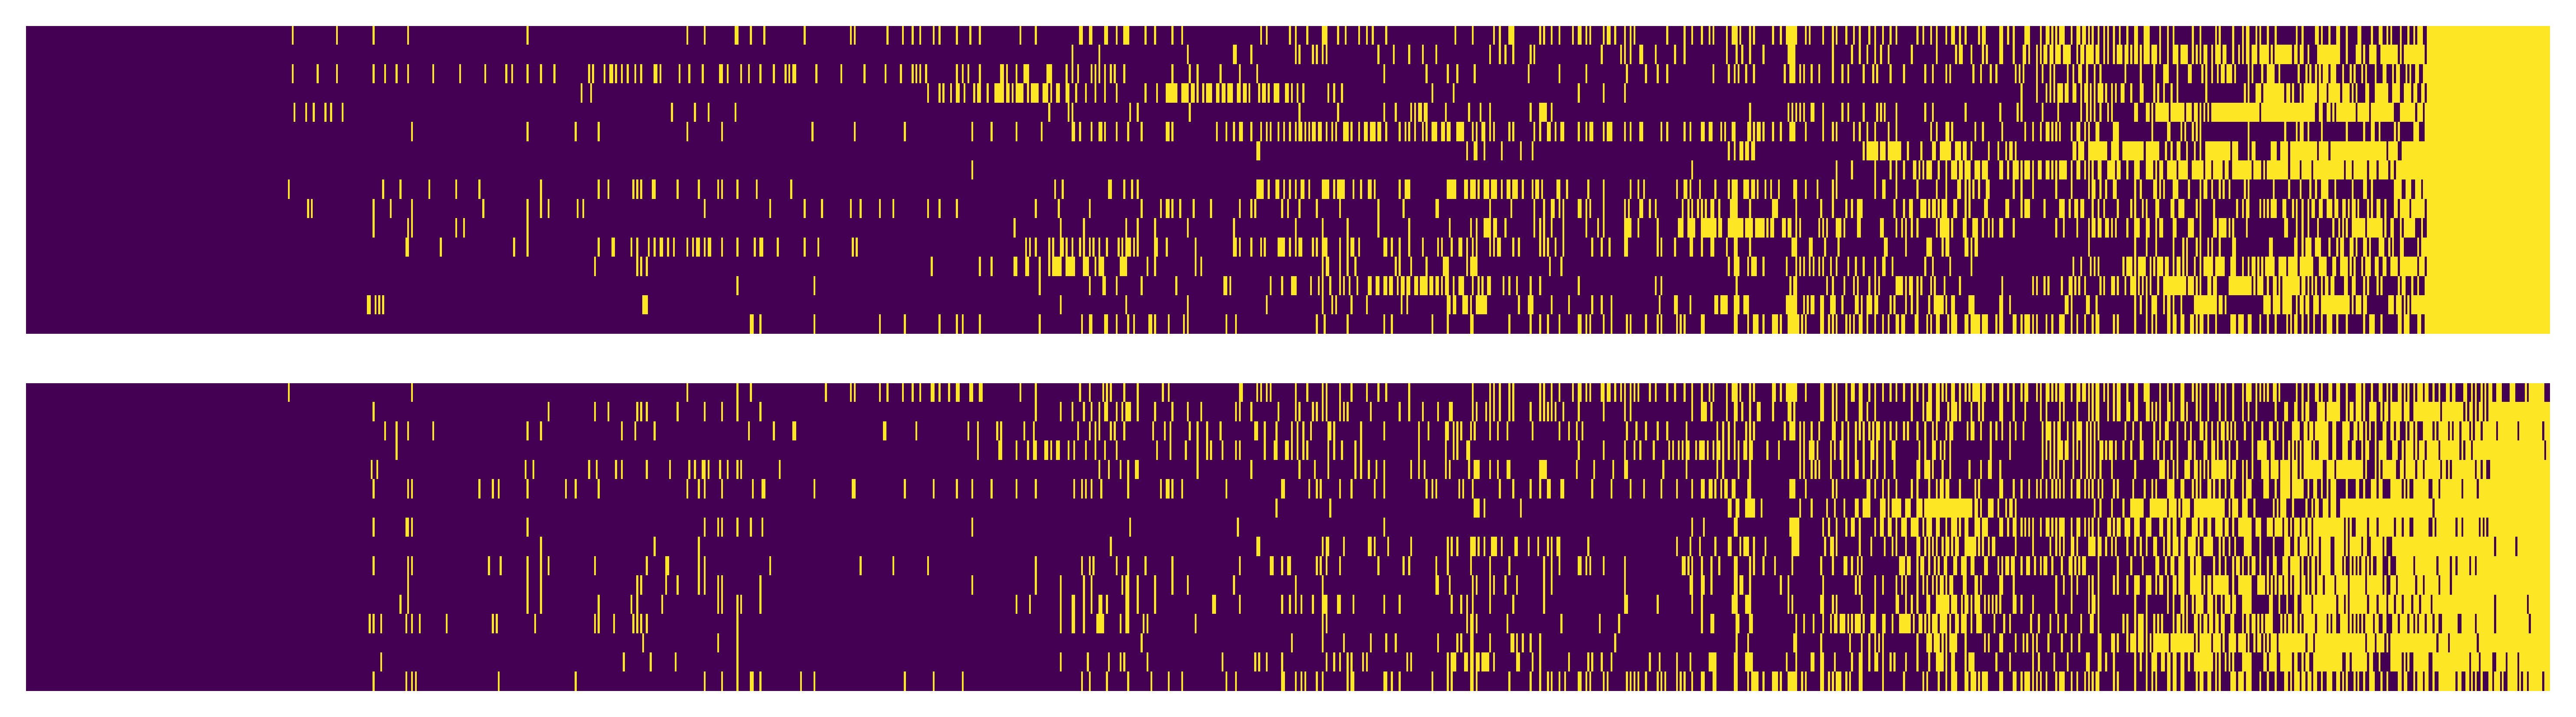

In [53]:
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 3), dpi=600)
ax0.imshow(replacement.ann_masks[0][0, :, 0, :], aspect=10)
ax1.imshow(replacement.topk_masks[0][0, :, 0, :], aspect=10)
ax0.axis("off"); ax1.axis("off")
plt.tight_layout()

---

# Eviction importance

In [6]:
emasks = []
settingses = [
    L.eviction_attention.Settings(k=512, local_k=128, importance=L.eviction_attention.Importance.Settings(metric="weight", metric_threshold=None, reduction="sum", reduction_decay=None)),
    L.eviction_attention.Settings(k=512, local_k=128, importance=L.eviction_attention.Importance.Settings(metric="global_threshold", metric_threshold=1, reduction="decaymax", reduction_decay=1000)),
]
for settings in settingses:
    adapter.model = L.eviction_attention.convert_gptneox(original_model, settings)
    layer = adapter.model.gpt_neox.layers[12].attention
    layer.detailed_logging = True
    list(L.qa.evaluate(adapter, examples[:2], batch_size=2, use_cache=False, output_token_limit=1))
    emasks.append(layer.eviction_masks[0])

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:22<00:00, 22.11s/it]


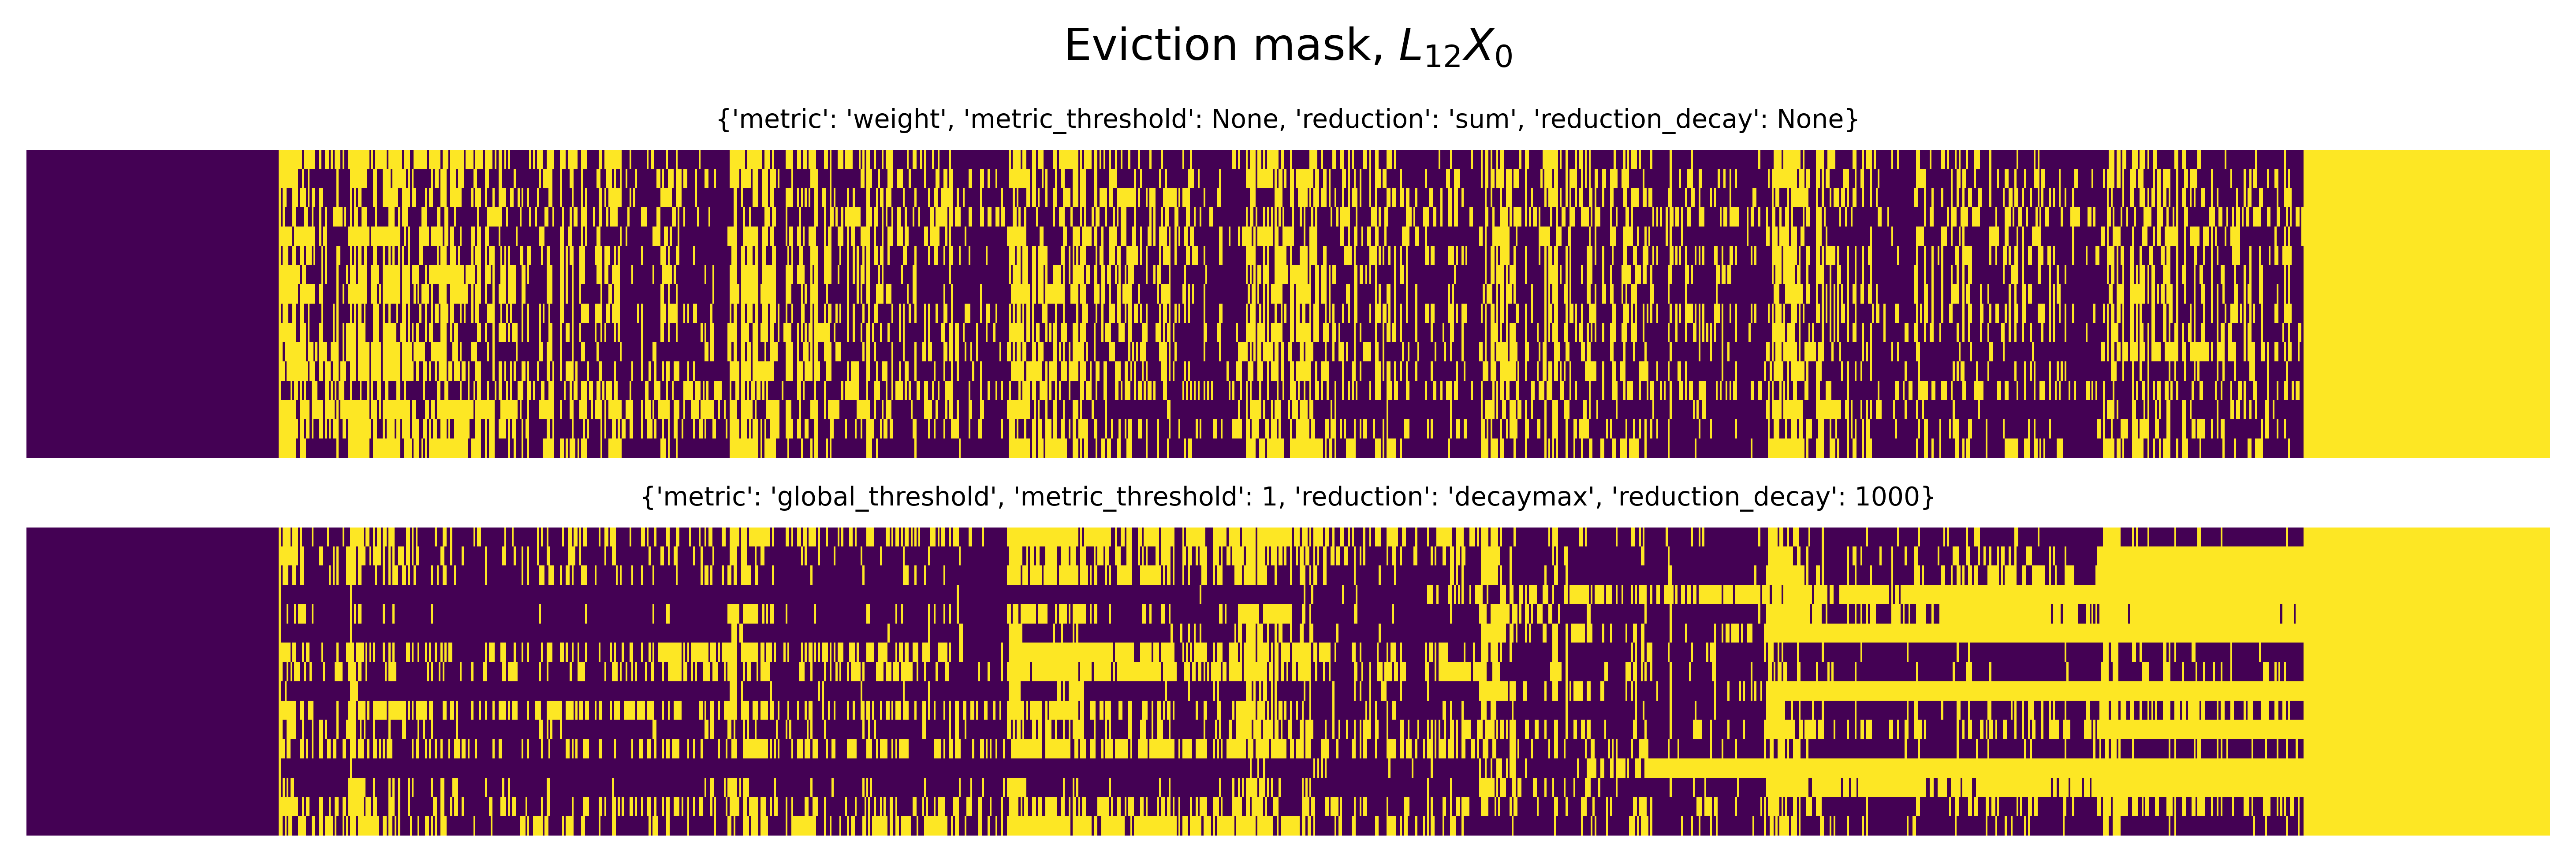

In [19]:
_, axs = plt.subplots(len(emasks), 1, figsize=(10, 1.5*len(emasks)), dpi=600)
for ax, mask, settings in zip(axs.flatten(), emasks, settingses):
    ax.imshow(mask[0], aspect=10)
    ax.set_title(str(settings.importance.__dict__), fontsize=7)
    ax.tick_params(axis="x", bottom=False, labelbottom=False)
    ax.tick_params(axis="y", left=False, labelleft=False)
    ax.axis("off")
plt.tight_layout(h_pad=1.5)
plt.suptitle(r"Eviction mask, $L_{12}X_0$", y=1.07);

## Exploration

In [49]:
adapter.model = L.eviction_attention.convert_gptneox(
    original_model, L.eviction_attention.Settings(k=512, local_k=128, importance=L.eviction_attention.Importance.Settings(
        metric="log_weight", metric_threshold=None, reduction="mean", reduction_decay=200)),
)
for layer in adapter.model.gpt_neox.layers:
    layer.attention.detailed_logging = True
list(L.qa.evaluate(adapter, examples[:2], batch_size=2, use_cache=False, output_token_limit=2))

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 1/1 [00:13<00:00, 13.28s/it]


[{'id': '5711607f2419e314009555cf',
  'output': ' electric power',
  'match': False,
  'prefill_length': 1178},
 {'id': '570d4329fed7b91900d45dd7',
  'output': ' 1 July',
  'match': False,
  'prefill_length': 1309}]

In [43]:
layer.history[0].score[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

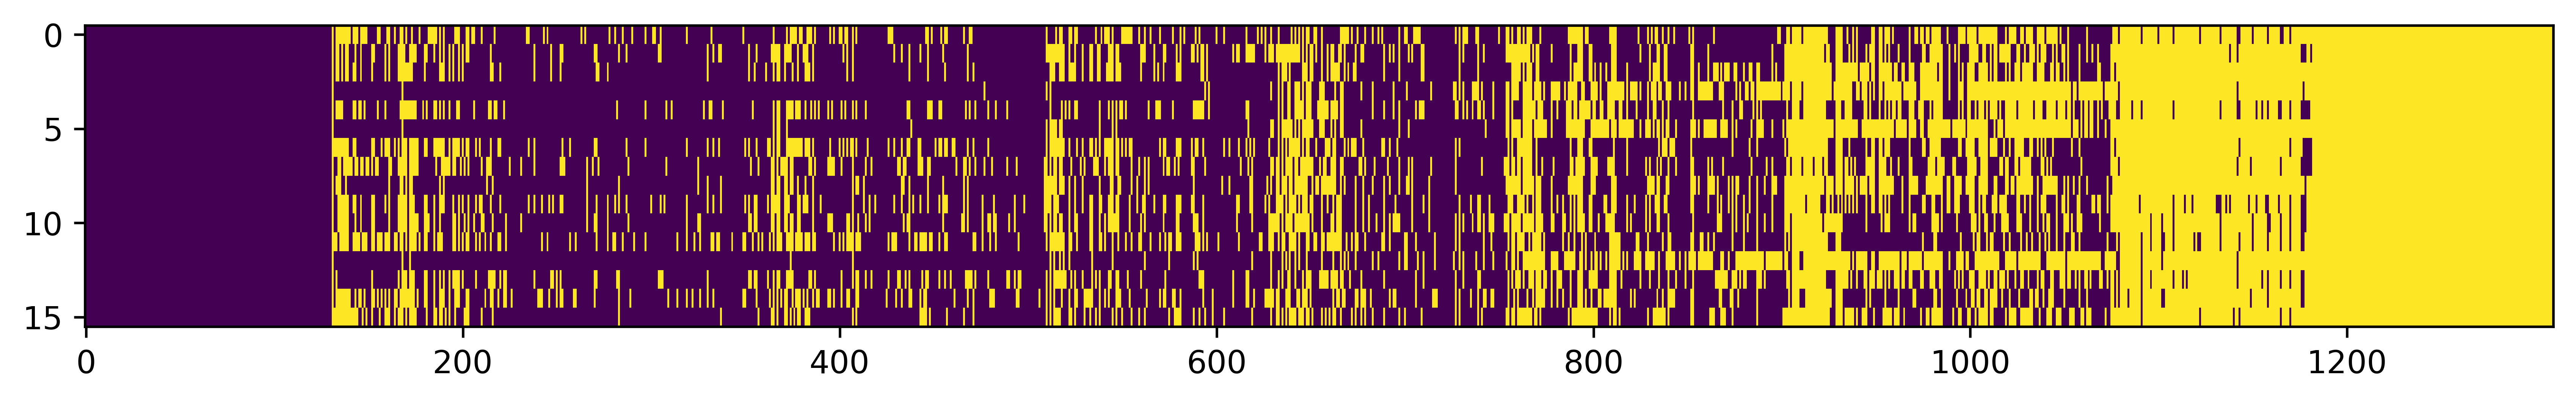

In [50]:
layer = adapter.model.gpt_neox.layers[12].attention
mask = layer.eviction_masks[0]
plt.figure(figsize=(14, 6), dpi=600)
plt.imshow(mask[0], aspect=10)

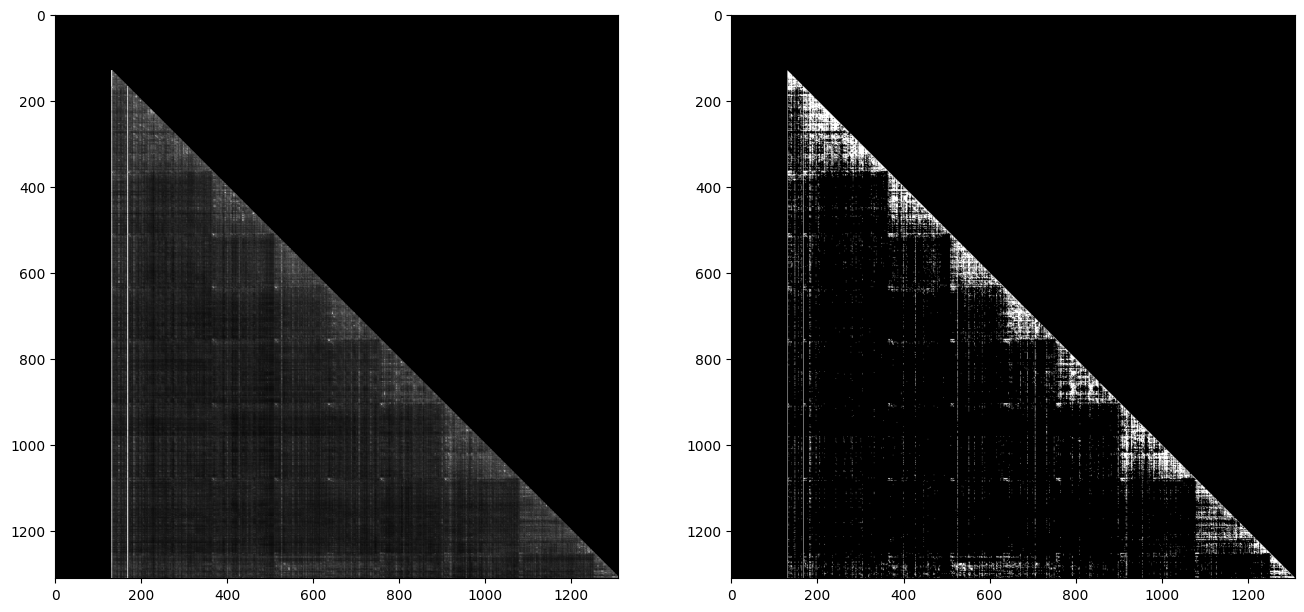

In [50]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
ax0.imshow(layer.weights[0][0, 0], norm=matplotlib.colors.PowerNorm(0.2), cmap="gray")
ax1.imshow(layer.weights[0][0, 0] > 1/2048, cmap="gray")